In [14]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import os

BASE_DIR = "/content/drive/MyDrive/Files"
print(os.listdir(BASE_DIR))

['tabular_xgb.pkl', 'train_clean.zip', 'sentinel_images.zip', 'data', 'image_only_resnet.pth', 'image_only_model.ipynb', 'sentinel_test.zip', 'MultimodalFusion.ipynb', 'test.ipynb']


In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [17]:

#Image Encoder
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(pretrained=False)
        num_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.project = nn.Sequential(
            nn.Linear(num_feats, 256),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.backbone(x)
        return self.project(x)


In [18]:
image_encoder = ImageEncoder()
image_encoder.backbone.load_state_dict(
    torch.load(f"{BASE_DIR}/image_only_resnet.pth", map_location=device),
    strict=False
)
image_encoder.to(device)


ImageEncoder(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [19]:
# Tabular Encoder (MLP)
class TabularEncoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)


In [20]:
# Multimodal Regressor (Late Fusion)
class MultimodalRegressor(nn.Module):
    def __init__(self, tabular_dim):
        super().__init__()

        self.image_encoder = image_encoder
        self.tabular_encoder = TabularEncoder(tabular_dim)

        self.regressor = nn.Sequential(
            nn.Linear(256 + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1)
        )

    def forward(self, image, tabular):
        img_feat = self.image_encoder(image)
        tab_feat = self.tabular_encoder(tabular)
        fused = torch.cat([img_feat, tab_feat], dim=1)
        return self.regressor(fused).squeeze(1)


In [21]:
# Dataset (Image + Tabular)
from torch.utils.data import Dataset
from PIL import Image

class MultimodalDataset(Dataset):
    def __init__(self, image_paths, tabular, targets, transform=None):
        self.image_paths = image_paths
        self.tabular = tabular
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, self.tabular[idx], self.targets[idx]


In [22]:
# Training & Evaluation Functions
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for imgs, tabs, y in loader:
        imgs, tabs, y = imgs.to(device), tabs.to(device), y.to(device)

        optimizer.zero_grad()
        preds = model(imgs, tabs)
        loss = criterion(preds, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [23]:
def evaluate_rmse_both(model, loader):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for imgs, tabs, y in loader:
            imgs = imgs.to(device)
            tabs = tabs.to(device)

            out = model(imgs, tabs)   # log-price predictions

            preds.append(out.cpu())
            targets.append(y.cpu())   # log-price targets

    preds = torch.cat(preds)
    targets = torch.cat(targets)

    # ---- LOG RMSE ----
    log_rmse = torch.sqrt(torch.mean((preds - targets) ** 2)).item()

    # ---- REAL PRICE RMSE ----
    preds_real = torch.expm1(preds)
    targets_real = torch.expm1(targets)
    real_rmse = torch.sqrt(torch.mean((preds_real - targets_real) ** 2)).item()

    return log_rmse, real_rmse


In [24]:
import pandas as pd

df = pd.read_csv(f"{BASE_DIR}/data/processed/train_clean.csv")
# print(df.columns.tolist())

In [25]:
TABULAR_COLS =['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
TARGET_COL = "price"

In [27]:

import os

IMAGE_DIR = f"{BASE_DIR}/data/images/sentinel"

available_image_ids = sorted([
    int(f.split('.')[0])
    for f in os.listdir(IMAGE_DIR)
    if f.endswith(('.jpg', '.png'))
])

print(len(available_image_ids))

In [28]:
#
df = df.iloc[available_image_ids].reset_index(drop=True)


In [29]:
X_tab = torch.tensor(df[TABULAR_COLS].values, dtype=torch.float32)
y = torch.tensor(np.log1p(df[TARGET_COL].values), dtype=torch.float32)


In [30]:

import os

IMAGE_DIR = f"{BASE_DIR}/data/images/sentinel"

image_paths = [
    os.path.join(IMAGE_DIR, f"{i}.png")
    for i in available_image_ids
]


In [31]:
from sklearn.model_selection import train_test_split

(
    img_train, img_val,
    tab_train, tab_val,
    y_train, y_val
) = train_test_split(
    image_paths,
    X_tab,
    y,
    test_size=0.2,
    random_state=42
)


In [32]:
from torchvision import transforms

train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [33]:
train_dataset = MultimodalDataset(
    img_train,
    tab_train,
    y_train,
    transform=train_tfms
)

val_dataset = MultimodalDataset(
    img_val,
    tab_val,
    y_val,
    transform=val_tfms
)


In [34]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [35]:
# imgs, tabs, y = next(iter(train_loader))
# print(imgs.shape)   # (B, 3, 224, 224)
# print(tabs.shape)   # (B, TABULAR_DIM)
# print(y.shape)      # (B,)


In [36]:
train_dataset = MultimodalDataset(image_paths, X_tab, y, transform=train_tfms)



In [37]:
# print(len(image_paths), len(X_tab), len(y))


In [42]:
TABULAR_DIM = train_dataset[0][1].shape[0]
print("Tabular feature dimension:", TABULAR_DIM)


Tabular feature dimension: 17


# Multimodal Regression

In [39]:
# Train Day-6 Model (Frozen CNN)
model = MultimodalRegressor(tabular_dim=TABULAR_DIM).to(device)

# Freeze CNN
for p in model.image_encoder.parameters():
    p.requires_grad = False

optimizer = torch.optim.Adam(
    list(model.tabular_encoder.parameters()) +
    list(model.regressor.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)

criterion = nn.MSELoss()

In [40]:
# for epoch in range(10):
#     train_loss = train_epoch(model, train_loader, optimizer, criterion)
#     val_rmse = evaluate_rmse(model, val_loader)

#     print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val RMSE={val_rmse:.4f}")

# # Training Loop (Day 6 / baseline)
# for epoch in range(25):
#     train_loss = train_epoch(model, train_loader, optimizer, criterion)

#     log_rmse, real_rmse = evaluate_rmse_both(model, val_loader)

#     print(
#         f"Epoch {epoch+1} | "
#         f"Train Loss (log MSE): {train_loss:.4f} | "
#         f"Log RMSE: {log_rmse:.4f} | "
#         f"Real RMSE: {real_rmse:,.0f}"
#     )


In [41]:
EPOCHS = 20
PATIENCE = 4
MIN_DELTA = 0.002  # minimum improvement to reset patience

best_log_rmse = float("inf")
patience_counter = 0
UNFREEZE_EPOCH = 5

for param in model.image_encoder.backbone.parameters():
    param.requires_grad = False

for epoch in range(EPOCHS):
  # late

    if epoch == UNFREEZE_EPOCH:
        for param in model.image_encoder.backbone.layer4.parameters():
            param.requires_grad = True

    # --- Training ---
    train_loss = train_epoch(model, train_loader, optimizer, criterion)

    # --- Validation ---
    log_rmse, real_rmse = evaluate_rmse_both(model, val_loader)

    print(
        f"Epoch {epoch+1} | "
        f"Train Loss (log MSE): {train_loss:.4f} | "
        f"Log RMSE: {log_rmse:.4f} | "
        f"Real RMSE: {real_rmse:,.0f}"
    )

    # --- Early Stopping ---
    if log_rmse < best_log_rmse - MIN_DELTA:
        best_log_rmse = log_rmse
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), "multimodal_model_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break


Epoch 1 | Train Loss (log MSE): 10.7016 | Log RMSE: 0.6645 | Real RMSE: 356,983
Epoch 2 | Train Loss (log MSE): 2.1261 | Log RMSE: 0.5351 | Real RMSE: 353,840
Epoch 3 | Train Loss (log MSE): 2.0324 | Log RMSE: 0.7889 | Real RMSE: 406,495
Epoch 4 | Train Loss (log MSE): 1.9596 | Log RMSE: 0.9549 | Real RMSE: 436,962
Epoch 5 | Train Loss (log MSE): 1.8340 | Log RMSE: 0.5044 | Real RMSE: 374,792
Epoch 6 | Train Loss (log MSE): 1.7126 | Log RMSE: 0.5653 | Real RMSE: 562,613
Epoch 7 | Train Loss (log MSE): 1.6890 | Log RMSE: 0.4570 | Real RMSE: 294,050
Epoch 8 | Train Loss (log MSE): 1.6325 | Log RMSE: 0.4937 | Real RMSE: 318,614
Epoch 9 | Train Loss (log MSE): 1.6421 | Log RMSE: 0.5133 | Real RMSE: 381,979
Epoch 10 | Train Loss (log MSE): 1.5897 | Log RMSE: 0.4829 | Real RMSE: 355,568
Epoch 11 | Train Loss (log MSE): 1.5612 | Log RMSE: 0.5068 | Real RMSE: 326,922
Early stopping triggered at epoch 11


In [43]:
torch.save(model.state_dict(), f"{BASE_DIR}/multimodal_day6.pth")

print("Saved files:")
print(os.listdir(BASE_DIR))

Saved files:
['tabular_xgb.pkl', 'train_clean.zip', 'sentinel_images.zip', 'data', 'image_only_resnet.pth', 'image_only_model.ipynb', 'sentinel_test.zip', 'MultimodalFusion.ipynb', 'test.ipynb', 'multimodal_day6.pth']


# **Fine Tune**

In [44]:
# Unfreeze Last CNN Block
for param in model.image_encoder.backbone.layer4.parameters():
    param.requires_grad = True

In [45]:
# Differential Learning Rates
optimizer2 = torch.optim.Adam([
    {"params": model.image_encoder.backbone.layer4.parameters(), "lr": 1e-5},
    {"params": model.image_encoder.project.parameters(), "lr": 1e-4},
    {"params": model.tabular_encoder.parameters(), "lr": 1e-3},
    {"params": model.regressor.parameters(), "lr": 1e-3},
    # weight_deacy=5e-4
])


In [46]:
for i, param_group in enumerate(optimizer2.param_groups):
    print(f"LR group {i}: {param_group['lr']}")

LR group 0: 1e-05
LR group 1: 0.0001
LR group 2: 0.001
LR group 3: 0.001


In [47]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=2, factor=0.5, min_lr=1e-6
)

In [48]:
best_rmse = float("inf")
patience = 5
counter = 0
MIN_DELTA = 0.001

In [49]:
# # Fine-Tuning Loop
# for epoch in range(20):
#     train_loss = train_epoch(model, train_loader, optimizer2, criterion)
#     val_rmse = evaluate_rmse(model, val_loader)

#     scheduler.step(val_rmse)

#     print(f"[Day7] Epoch {epoch+1}: Val RMSE={val_rmse:.4f}")

#     if val_rmse < best_rmse:
#         best_rmse = val_rmse
#         counter = 0
#         torch.save(model.state_dict(), f"{BASE_DIR}/final_multimodal_model.pth")
#     else:
#         counter += 1
#         if counter >= patience:
#             print("Early stopping")
#             break

# Fine-Tuning Loop (Day 7)

EPOCHS = 30
UNFREEZE_EPOCH = 2
MIN_DELTA = 0.002

best_rmse = float("inf")
patience = 5
counter = 0

for param in model.image_encoder.backbone.parameters():
    param.requires_grad = False

for epoch in range(EPOCHS):
    if EPOCHS == UNFREEZE_EPOCH:
      print("Unfreezing CNN layer4 for fine-tuning")
      for param in model.image_encoder.backbone.layer4.parameters():
        param.requires_grad = True

    train_loss = train_epoch(model, train_loader, optimizer2, criterion)

    log_rmse, real_rmse = evaluate_rmse_both(model, val_loader)

    # Scheduler should step on log RMSE (scale-stable)
    scheduler.step(log_rmse)

    print(
        f"[Day7] Epoch {epoch+1} | "
        f"Train Loss (log MSE): {train_loss:.4f} | "
        f"Log RMSE: {log_rmse:.4f} | "
        f"Real RMSE: {real_rmse:,.0f}"
    )

    # Early stopping based on log RMSE
    if best_rmse - log_rmse > MIN_DELTA:
        best_rmse = log_rmse
        counter = 0
        torch.save(
            model.state_dict(),
            f"{BASE_DIR}/final_multimodal_model.pth"
        )
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break


[Day7] Epoch 1 | Train Loss (log MSE): 1.5558 | Log RMSE: 0.4713 | Real RMSE: 286,978
[Day7] Epoch 2 | Train Loss (log MSE): 1.4809 | Log RMSE: 0.5247 | Real RMSE: 320,007
[Day7] Epoch 3 | Train Loss (log MSE): 1.4257 | Log RMSE: 0.5102 | Real RMSE: 312,695
[Day7] Epoch 4 | Train Loss (log MSE): 1.4028 | Log RMSE: 0.5020 | Real RMSE: 285,655
[Day7] Epoch 5 | Train Loss (log MSE): 1.3664 | Log RMSE: 0.4240 | Real RMSE: 282,475
[Day7] Epoch 6 | Train Loss (log MSE): 1.2931 | Log RMSE: 0.5024 | Real RMSE: 306,464
[Day7] Epoch 7 | Train Loss (log MSE): 1.2401 | Log RMSE: 0.4067 | Real RMSE: 266,295
[Day7] Epoch 8 | Train Loss (log MSE): 1.1853 | Log RMSE: 0.3990 | Real RMSE: 253,901
[Day7] Epoch 9 | Train Loss (log MSE): 1.1668 | Log RMSE: 0.4242 | Real RMSE: 274,599
[Day7] Epoch 10 | Train Loss (log MSE): 1.1282 | Log RMSE: 0.3888 | Real RMSE: 263,560
[Day7] Epoch 11 | Train Loss (log MSE): 1.0569 | Log RMSE: 0.3836 | Real RMSE: 247,480
[Day7] Epoch 12 | Train Loss (log MSE): 1.0405 | Log

KeyboardInterrupt: 

# Grad-CAM

In [77]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [78]:
model.load_state_dict(
    torch.load(f"{BASE_DIR}/final_multimodal_model.pth", map_location=device)
)
model.eval()

MultimodalRegressor(
  (image_encoder): ImageEncoder(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [79]:
for p in model.image_encoder.parameters():
    p.requires_grad = True


In [80]:
# Grad-CAM Class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, image_tensor, tabular_tensor):
        self.model.zero_grad()

        output = self.model(image_tensor, tabular_tensor)
        # output.backward()
        output.backward(torch.ones_like(output))

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = torch.relu(cam)
        cam = cam.squeeze()
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam.cpu().numpy()


In [81]:
# Select Target Layer
target_layer = model.image_encoder.backbone.layer4[-1]
gradcam = GradCAM(model, target_layer)

In [113]:
# Run Grad-CAM on Validation Images
idx = 1245
img, tab, true_price = val_dataset[idx]

img_tensor = img.unsqueeze(0).to(device)
tab_tensor = tab.unsqueeze(0).to(device)


In [114]:
cam = gradcam.generate(img_tensor, tab_tensor)

In [115]:
# Overlay Heatmap on Image
def overlay_cam(image, cam):
    image = image.permute(1, 2, 0).numpy()
    image = (image - image.min()) / (image.max() - image.min())

    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    overlay = 0.8 * image + 0.2 * heatmap / 255
    return overlay

In [116]:
# for i in range(5):
#     img, _ = train_dataset[i]

#     cam = gradcam(img.unsqueeze(0).to(device))
#     overlay = overlay_cam(img, cam)

#     plt.figure(figsize=(4,4))
#     plt.imshow(overlay)
#     plt.axis("off")
#     plt.title(f"Sample {i}")
#     plt.show()

# for i in range(5):
#     img, tab, _ = train_dataset[i]

#     img = img.unsqueeze(0).to(device)
#     tab = tab.unsqueeze(0).to(device)

#     cam = gradcam.generate(img, tab)

#     image_np = img[0].permute(1, 2, 0).cpu().numpy()
#     overlay = overlay_cam(image_np, cam)

#     plt.figure(figsize=(4,4))
#     plt.imshow(overlay)
#     plt.axis("off")
#     plt.title(f"Sample {i}")
#     plt.show()


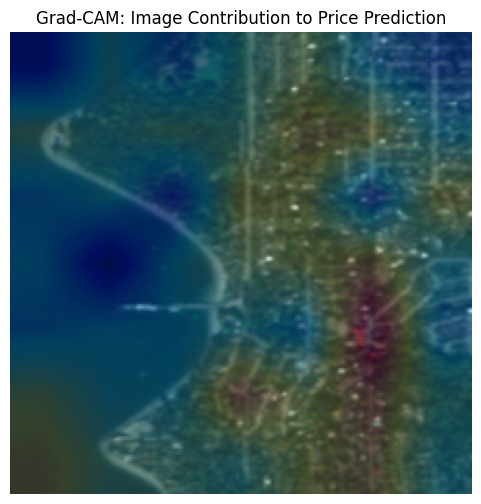

In [117]:
overlay = overlay_cam(img.cpu(), cam)

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.axis("off")
plt.title("Grad-CAM: Image Contribution to Price Prediction")
plt.show()